# 📱 EDA: База даних Statistic (Push-сповіщення)

**Мета**: Розвідувальний аналіз push-сповіщень для Android-користувачів за період 22.05–29.05

**Основні завдання**:
1. Вивчити структуру та якість даних
2. Проаналізувати розподіли по A/B групах і країнах
3. Дослідити часові паттерни відправки push-ів
4. Підготувати дані для подальшого аналізу

---

## 🔧 Налаштування середовища

In [2]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import logging

# Власні модулі
from config.database_config import DatabaseManager
from config.constants import *
from src.database import PushDatabase
from src.data_loader import DataLoader

# Налаштування
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# Логування
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("📦 Модулі завантажено успішно!")
print(f"📅 Період аналізу: {PUSH_START_DATE} - {PUSH_END_DATE}")
print(f"📱 Тип додатків: Android (type = {ANDROID_TYPE})")
print(f"🔔 Тип події: SendPush (event_type = {PUSH_EVENT_TYPE})")

📦 Модулі завантажено успішно!
📅 Період аналізу: 2025-05-22 - 2025-05-29
📱 Тип додатків: Android (type = 1)
🔔 Тип події: SendPush (event_type = 7)


## 🔗 Підключення до бази даних

In [3]:
# Ініціалізація підключення
db = PushDatabase(cache_enabled=True)
db_manager = DatabaseManager()

# Тестування підключення
print("🔍 Тестування підключення до statistic...")
try:
    stat_client = db_manager.connect_statistic()
    test_result = db_manager.query_to_df(stat_client, "SELECT 1 as test")
    print("✅ Підключення до statistic успішне!")
    
    # Перевірка доступних таблиць
    tables = db_manager.query_to_df(stat_client, "SHOW TABLES")
    print(f"📋 Доступні таблиці: {tables['name'].tolist()}")
    
except Exception as e:
    print(f"❌ Помилка підключення: {e}")
    raise

🔍 Тестування підключення до statistic...
✅ Підключено до statistic
✅ Підключення до statistic успішне!
📋 Доступні таблиці: ['device', 'device_with_date', 'event', 'event_backup', 'event_metrics_daily_aggregated', 'event_metrics_mv', 'event_trigger', 'postback_open', 'postback_open_with_date', 'temp_device', 'temp_event', 'temp_event_trigger', 'temp_postback_open']


## 🏗️ Дослідження структури даних

In [4]:
print("📊 ДОСЛІДЖЕННЯ СХЕМИ БД STATISTIC")
print("=" * 50)

# 1. Структура таблиці EVENT
print("\n🔍 Структура таблиці EVENT:")
event_schema = db_manager.query_to_df(stat_client, "DESCRIBE TABLE event")
print(event_schema[['name', 'type']].to_string(index=False))

# 2. Структура таблиці DEVICE
print("\n🔍 Структура таблиці DEVICE:")
device_schema = db_manager.query_to_df(stat_client, "DESCRIBE TABLE device")
print(device_schema[['name', 'type']].to_string(index=False))

# 3. Типи подій в EVENT
print("\n📋 Типи подій (event_type) в системі:")
event_types_query = """
SELECT 
    event_type,
    COUNT(*) as count,
    COUNT(DISTINCT device_id) as unique_devices
FROM event 
WHERE toDate(created_at) >= '2025-05-20' 
    AND toDate(created_at) <= '2025-05-30'
GROUP BY event_type 
ORDER BY count DESC
"""
event_types = db_manager.query_to_df(stat_client, event_types_query)
print(event_types.to_string(index=False))

# 4. Типи додатків
print("\n📱 Типи додатків (type) в системі:")
app_types_query = """
SELECT 
    e.type,
    CASE 
        WHEN e.type = 0 THEN 'PWA'
        WHEN e.type = 1 THEN 'Android'
        WHEN e.type = 2 THEN 'iOS'
        ELSE 'Unknown'
    END as app_type_name,
    COUNT(*) as count,
    COUNT(DISTINCT device_id) as unique_devices
FROM event e
WHERE toDate(e.created_at) >= '2025-05-20' 
    AND toDate(e.created_at) <= '2025-05-30'
GROUP BY e.type 
ORDER BY count DESC
"""
app_types = db_manager.query_to_df(stat_client, app_types_query)
print(app_types.to_string(index=False))

📊 ДОСЛІДЖЕННЯ СХЕМИ БД STATISTIC

🔍 Структура таблиці EVENT:
          name           type
            id           UUID
     device_id Nullable(UUID)
    event_type          Int16
application_id          Int32
          type           Int8
    created_at       DateTime
        fbclid         String
         sub_1          Int32
         sub_2         String
         sub_3         String
         sub_4          Int32
         sub_5         String
         sub_6          Int32
         sub_7         UInt64

🔍 Структура таблиці DEVICE:
          name             type
            id             UUID
        fbclid Nullable(String)
application_id  Nullable(Int32)
    ip_address Nullable(String)
    user_agent Nullable(String)
    created_at Nullable(UInt64)
           fcm Nullable(String)
         gadid   Nullable(UUID)
          type  Nullable(Int32)
        sub_id Nullable(String)
        active   Nullable(Bool)
           tag Nullable(String)
      timezone Nullable(String)
  country_na

## 🧹 Якість даних та пропуски

In [5]:
print("🔍 АНАЛІЗ ЯКОСТІ ДАНИХ")
print("=" * 40)

# 1. Загальна статистика push-подій
print("\n📊 Загальна статистика push-подій за період:")
general_stats_query = f"""
SELECT 
    COUNT(*) as total_push_events,
    COUNT(DISTINCT e.device_id) as unique_devices,
    COUNT(DISTINCT d.gadid) as unique_gadids,
    COUNT(DISTINCT d.tag) as unique_ab_groups,
    COUNT(DISTINCT d.country_name) as unique_countries,
    MIN(e.created_at) as earliest_push,
    MAX(e.created_at) as latest_push
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
"""
general_stats = db_manager.query_to_df(stat_client, general_stats_query)
print(general_stats.to_string(index=False))

# 2. Пропуски в ключових полях
print("\n❌ Аналіз пропусків у ключових полях:")
nulls_query = f"""
SELECT 
    COUNT(*) as total_records,
    SUM(CASE WHEN d.gadid IS NULL THEN 1 ELSE 0 END) as gadid_nulls,
    SUM(CASE WHEN d.tag IS NULL THEN 1 ELSE 0 END) as tag_nulls,
    SUM(CASE WHEN d.country_name IS NULL THEN 1 ELSE 0 END) as country_nulls,
    SUM(CASE WHEN e.sub_1 IS NULL THEN 1 ELSE 0 END) as sub_1_nulls,
    SUM(CASE WHEN e.sub_2 IS NULL THEN 1 ELSE 0 END) as sub_2_nulls
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
"""
nulls_stats = db_manager.query_to_df(stat_client, nulls_query)

# Обчислити відсотки
total_records = nulls_stats['total_records'].iloc[0]
print(f"Загальна кількість записів: {total_records:,}")
print(f"GADID пропуски: {nulls_stats['gadid_nulls'].iloc[0]:,} ({nulls_stats['gadid_nulls'].iloc[0]/total_records*100:.2f}%)")
print(f"TAG пропуски: {nulls_stats['tag_nulls'].iloc[0]:,} ({nulls_stats['tag_nulls'].iloc[0]/total_records*100:.2f}%)")
print(f"COUNTRY пропуски: {nulls_stats['country_nulls'].iloc[0]:,} ({nulls_stats['country_nulls'].iloc[0]/total_records*100:.2f}%)")
print(f"SUB_1 пропуски: {nulls_stats['sub_1_nulls'].iloc[0]:,} ({nulls_stats['sub_1_nulls'].iloc[0]/total_records*100:.2f}%)")
print(f"SUB_2 пропуски: {nulls_stats['sub_2_nulls'].iloc[0]:,} ({nulls_stats['sub_2_nulls'].iloc[0]/total_records*100:.2f}%)")

# 3. Дублікати GADID
print("\n🔄 Аналіз дублікатів GADID:")
duplicates_query = f"""
WITH gadid_counts AS (
    SELECT 
        d.gadid,
        COUNT(*) as push_count,
        COUNT(DISTINCT d.tag) as ab_groups_count
    FROM event e
    JOIN device d ON e.device_id = d.id
    WHERE e.event_type = {PUSH_EVENT_TYPE}
        AND e.type = {ANDROID_TYPE}
        AND d.gadid IS NOT NULL
        AND toDate(e.created_at) >= '{PUSH_START_DATE}'
        AND toDate(e.created_at) <= '{PUSH_END_DATE}'
    GROUP BY d.gadid
)
SELECT 
    COUNT(*) as unique_gadids,
    AVG(push_count) as avg_pushes_per_gadid,
    MAX(push_count) as max_pushes_per_gadid,
    SUM(CASE WHEN ab_groups_count > 1 THEN 1 ELSE 0 END) as gadids_with_multiple_ab_groups
FROM gadid_counts
"""
duplicates_stats = db_manager.query_to_df(stat_client, duplicates_query)
print(duplicates_stats.to_string(index=False))

🔍 АНАЛІЗ ЯКОСТІ ДАНИХ

📊 Загальна статистика push-подій за період:
 total_push_events  unique_devices  unique_gadids  unique_ab_groups  unique_countries             earliest_push               latest_push
          73360456         3461709        2956767                 6               207 2025-05-22 00:03:53+00:00 2025-05-29 23:50:06+00:00

❌ Аналіз пропусків у ключових полях:
Загальна кількість записів: 73,360,456
GADID пропуски: 0 (0.00%)
TAG пропуски: 3,396,374 (4.63%)
COUNTRY пропуски: 44,382,456 (60.50%)
SUB_1 пропуски: 0 (0.00%)
SUB_2 пропуски: 0 (0.00%)

🔄 Аналіз дублікатів GADID:
 unique_gadids  avg_pushes_per_gadid  max_pushes_per_gadid  gadids_with_multiple_ab_groups
       2956767             24.811037               2068668                          232082


## ⏰ Часовий аналіз push-сповіщень

📈 ЧАСОВИЙ АНАЛІЗ PUSH-СПОВІЩЕНЬ

📅 Push-и по днях:
      date  total_pushes  unique_users  avg_success_rate  ab_groups_active
2025-05-22       7479575       2612885          0.194821                 6
2025-05-23       9400573       2723249          0.188635                 6
2025-05-24       9503420       2761095          0.187476                 5
2025-05-25       9624277       2803258          0.184869                 5
2025-05-26       8441647       2811977          0.183675                 6
2025-05-27      10473308       2885732          0.181629                 6
2025-05-28       9765271       2916232          0.182131                 6
2025-05-29       8672385       2891728          0.184799                 6


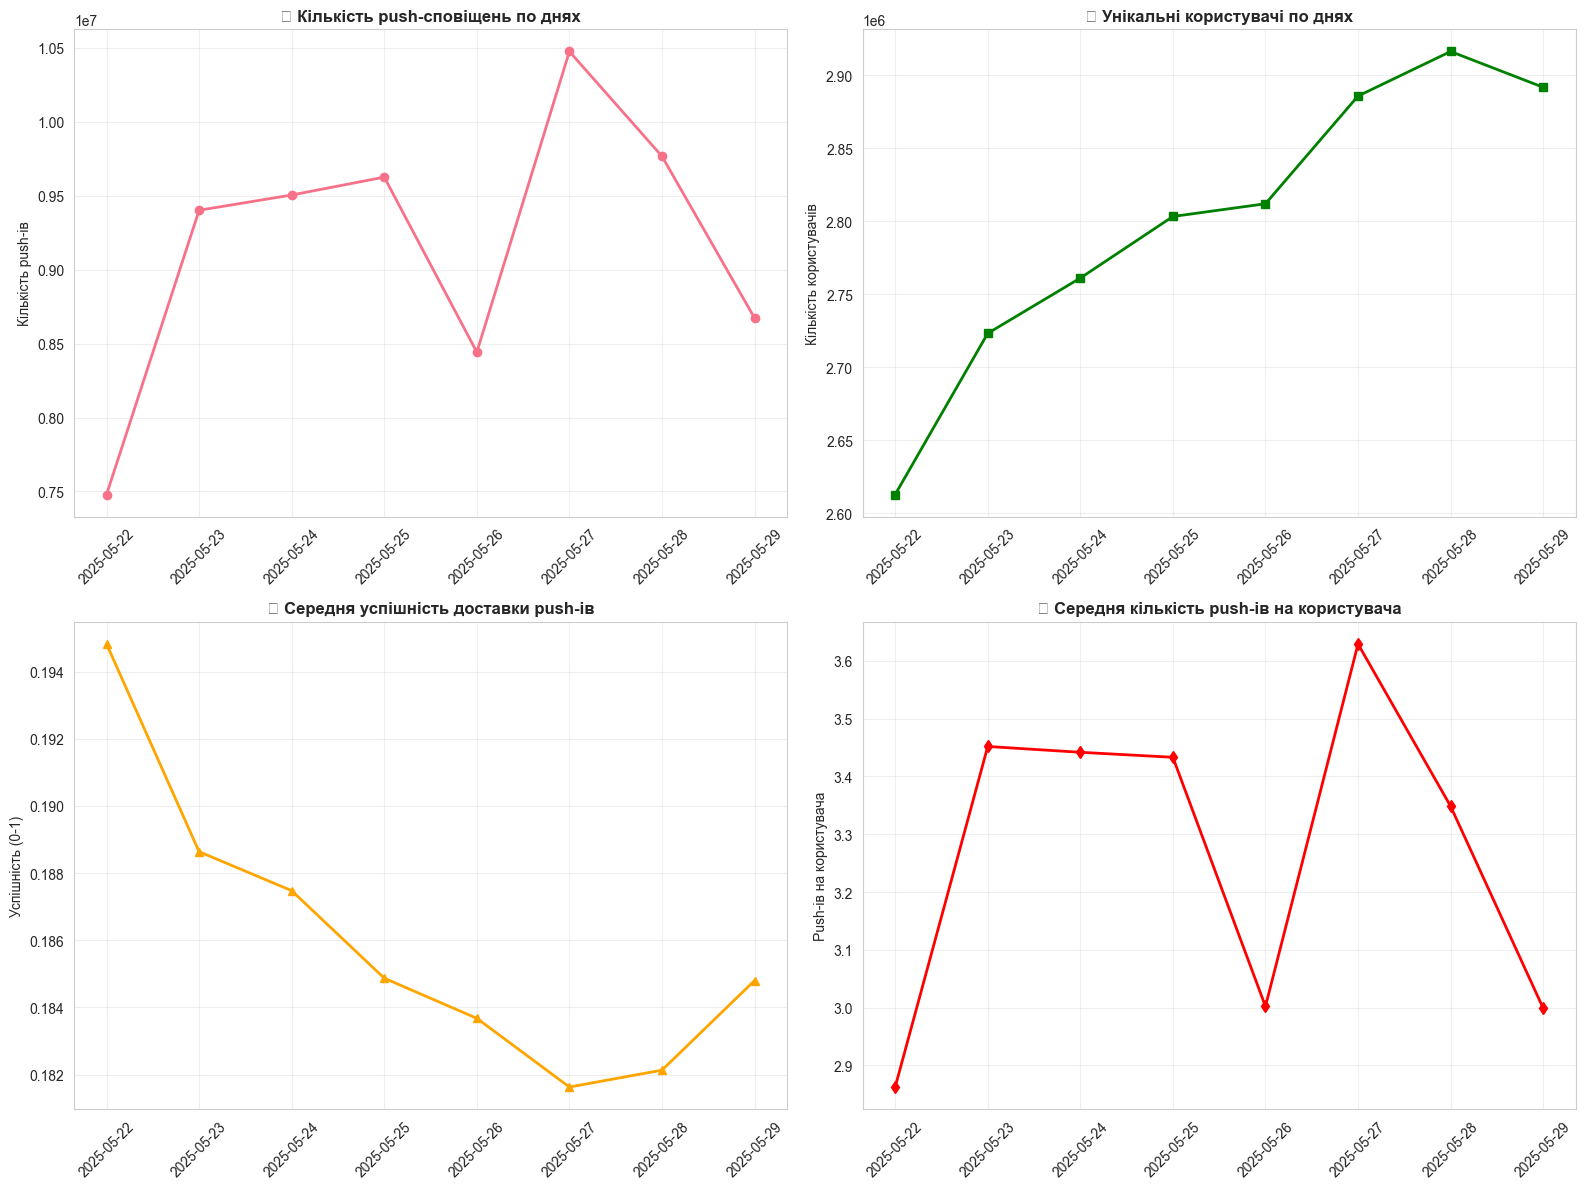


✅ Графік збережено: outputs/charts/daily_push_analysis.png


In [6]:
print("📈 ЧАСОВИЙ АНАЛІЗ PUSH-СПОВІЩЕНЬ")
print("=" * 45)

# 1. Push-и по днях
daily_push_query = f"""
SELECT 
    toDate(e.created_at) as date,
    COUNT(*) as total_pushes,
    COUNT(DISTINCT d.gadid) as unique_users,
    AVG(e.sub_1) as avg_success_rate,
    COUNT(DISTINCT d.tag) as ab_groups_active
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY toDate(e.created_at)
ORDER BY date
"""
daily_pushes = db_manager.query_to_df(stat_client, daily_push_query)
daily_pushes['date'] = pd.to_datetime(daily_pushes['date'])

print("\n📅 Push-и по днях:")
print(daily_pushes.to_string(index=False))

# Візуалізація щоденної активності
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Кількість push-ів по днях
axes[0,0].plot(daily_pushes['date'], daily_pushes['total_pushes'], marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('📊 Кількість push-сповіщень по днях', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Кількість push-ів')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# График 2: Унікальні користувачі по днях
axes[0,1].plot(daily_pushes['date'], daily_pushes['unique_users'], marker='s', color='green', linewidth=2, markersize=6)
axes[0,1].set_title('👥 Унікальні користувачі по днях', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Кількість користувачів')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# График 3: Середня успішність доставки
axes[1,0].plot(daily_pushes['date'], daily_pushes['avg_success_rate'], marker='^', color='orange', linewidth=2, markersize=6)
axes[1,0].set_title('📈 Середня успішність доставки push-ів', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Успішність (0-1)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# График 4: Push-и на користувача
daily_pushes['pushes_per_user'] = daily_pushes['total_pushes'] / daily_pushes['unique_users']
axes[1,1].plot(daily_pushes['date'], daily_pushes['pushes_per_user'], marker='d', color='red', linewidth=2, markersize=6)
axes[1,1].set_title('📱 Середня кількість push-ів на користувача', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Push-ів на користувача')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/daily_push_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/daily_push_analysis.png")


🕐 Аналіз push-ів по годинах:


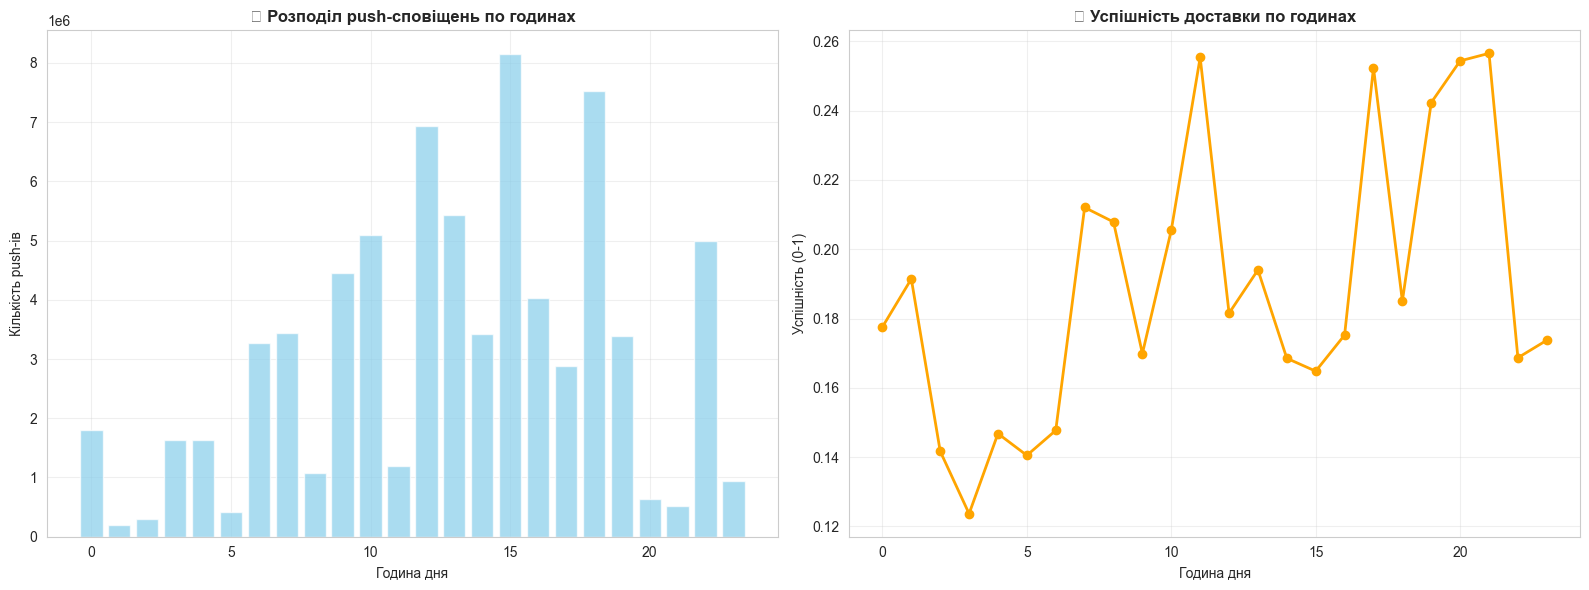


📊 Топ-3 години за кількістю push-ів:
 hour  total_pushes  avg_success_rate
   15       8142098          0.164804
   18       7520817          0.185051
   12       6941091          0.181529


In [7]:
# 2. Push-и по годинах (паттерни протягом дня)
print("\n🕐 Аналіз push-ів по годинах:")
hourly_push_query = f"""
SELECT 
    toHour(e.created_at) as hour,
    COUNT(*) as total_pushes,
    COUNT(DISTINCT d.gadid) as unique_users,
    AVG(e.sub_1) as avg_success_rate
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY toHour(e.created_at)
ORDER BY hour
"""
hourly_pushes = db_manager.query_to_df(stat_client, hourly_push_query)

# Графік розподілу по годинах
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Кількість push-ів по годинах
axes[0].bar(hourly_pushes['hour'], hourly_pushes['total_pushes'], alpha=0.7, color='skyblue')
axes[0].set_title('🕐 Розподіл push-сповіщень по годинах', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Година дня')
axes[0].set_ylabel('Кількість push-ів')
axes[0].grid(True, alpha=0.3)

# График 2: Успішність по годинах
axes[1].plot(hourly_pushes['hour'], hourly_pushes['avg_success_rate'], marker='o', color='orange', linewidth=2)
axes[1].set_title('📈 Успішність доставки по годинах', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Година дня')
axes[1].set_ylabel('Успішність (0-1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/hourly_push_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Топ-3 години за кількістю push-ів:")
top_hours = hourly_pushes.nlargest(3, 'total_pushes')[['hour', 'total_pushes', 'avg_success_rate']]
print(top_hours.to_string(index=False))

## 🧪 Аналіз A/B груп (tag)

🧪 АНАЛІЗ A/B ГРУП (TAG) - ВКЛЮЧАЮЧИ КОНТРОЛЬНУ ГРУПУ

🔍 Завантаження даних A/B груп з урахуванням контрольної групи...
Завантаження push-груп (1-5)...
Завантаження контрольної групи (6)...

📊 Розподіл користувачів по A/B групах (ВКЛЮЧАЮЧИ КОНТРОЛЬНУ ГРУПУ):
ab_group  unique_users  total_pushes  avg_success_rate  avg_pushes_per_user                first_push                 last_push
       1        619194       4913241            0.1920             7.934898 2025-05-22 00:03:54+00:00 2025-05-29 23:50:05+00:00
       2        621206       9644140            0.1903            15.524866 2025-05-22 00:03:53+00:00 2025-05-29 23:50:05+00:00
       3        620274      14158389            0.1892            22.826024 2025-05-22 00:03:53+00:00 2025-05-29 23:50:06+00:00
       4        620457      18512086            0.1890            29.836211 2025-05-22 00:03:53+00:00 2025-05-29 23:50:06+00:00
       5        622527      22735678            0.1883            36.521593 2025-05-22 00:03:53+00:00 

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

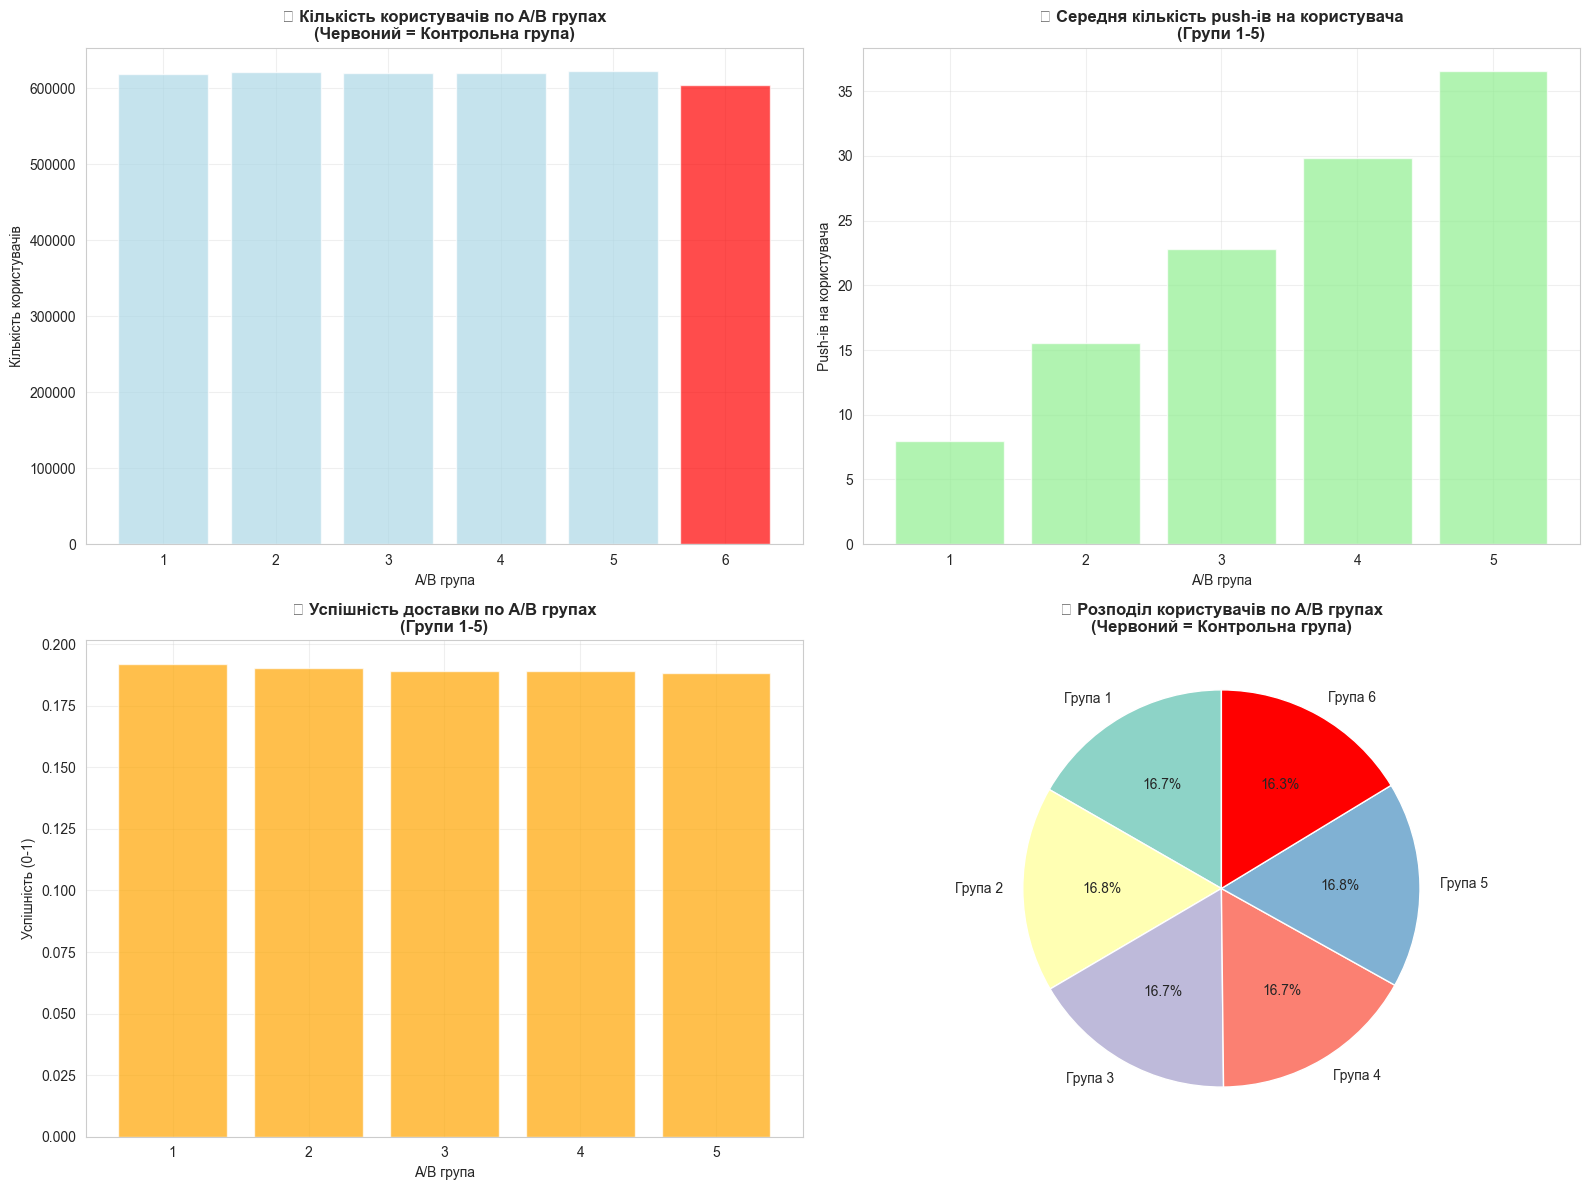


✅ Графік збережено: outputs/charts/ab_groups_analysis_with_control.png


In [8]:
print("🧪 АНАЛІЗ A/B ГРУП (TAG) - ВКЛЮЧАЮЧИ КОНТРОЛЬНУ ГРУПУ")
print("=" * 60)

# 1. Розподіл користувачів по A/B групах - ОНОВЛЕНИЙ ЗАПИТ
print("\n🔍 Завантаження даних A/B груп з урахуванням контрольної групи...")

# Спочатку отримуємо push-групи (1-5)
ab_push_query = f"""
SELECT 
    d.tag as ab_group,
    COUNT(DISTINCT d.gadid) as unique_users,
    COUNT(*) as total_pushes,
    ROUND(AVG(e.sub_1), 4) as avg_success_rate,
    COUNT(*) / COUNT(DISTINCT d.gadid) as avg_pushes_per_user,
    MIN(e.created_at) as first_push,
    MAX(e.created_at) as last_push
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND d.tag IS NOT NULL
    AND d.tag IN ('1', '2', '3', '4', '5')
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY d.tag
ORDER BY d.tag
"""

# Окремо отримуємо контрольну групу (група 6 - без push-ів)
ab_control_query = f"""
SELECT 
    '6' as ab_group,
    COUNT(DISTINCT gadid) as unique_users,
    0 as total_pushes,
    NULL as avg_success_rate,
    0 as avg_pushes_per_user,
    NULL as first_push,
    NULL as last_push
FROM device
WHERE tag = '6'
    AND type = {ANDROID_TYPE}
    AND gadid IS NOT NULL
"""

print("Завантаження push-груп (1-5)...")
ab_push_groups = db_manager.query_to_df(stat_client, ab_push_query)

print("Завантаження контрольної групи (6)...")
ab_control_group = db_manager.query_to_df(stat_client, ab_control_query)

# Об'єднуємо всі групи
ab_groups = pd.concat([ab_push_groups, ab_control_group], ignore_index=True)
ab_groups['ab_group'] = ab_groups['ab_group'].astype(str)
ab_groups = ab_groups.sort_values('ab_group')

print("\n📊 Розподіл користувачів по A/B групах (ВКЛЮЧАЮЧИ КОНТРОЛЬНУ ГРУПУ):")
print(ab_groups.to_string(index=False))

# Обчислення додаткових метрик
total_users = ab_groups['unique_users'].sum()
ab_groups['user_percentage'] = (ab_groups['unique_users'] / total_users * 100).round(2)
ab_groups['group_type'] = ab_groups['ab_group'].apply(lambda x: 'Control Group' if x == '6' else 'Push Group')

print("\n📈 Детальний розподіл:")
ab_summary = ab_groups[['ab_group', 'group_type', 'unique_users', 'user_percentage', 'avg_pushes_per_user', 'avg_success_rate']]
print(ab_summary.to_string(index=False))

# Перевірка коректності контрольної групи
control_group = ab_groups[ab_groups['ab_group'] == '6']
if not control_group.empty:
    control_users = control_group['unique_users'].iloc[0]
    print(f"\n✅ КОНТРОЛЬНА ГРУПА ЗНАЙДЕНА:")
    print(f"   • Користувачів у групі 6: {control_users:,}")
    if control_users > 500000:
        print(f"   • ✅ Кількість реалістична (> 500K)")
    else:
        print(f"   • ⚠️ Можлива проблема: занадто мало користувачів")
else:
    print("❌ ПОМИЛКА: Контрольна група не знайдена!")

# Візуалізація A/B груп з контрольною групою
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Розподіл користувачів по A/B групах з виділенням контрольної групи
colors = ['red' if group == '6' else 'lightblue' for group in ab_groups['ab_group']]
axes[0,0].bar(ab_groups['ab_group'], ab_groups['unique_users'], alpha=0.7, color=colors)
axes[0,0].set_title('👥 Кількість користувачів по A/B групах\n(Червоний = Контрольна група)', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('A/B група')
axes[0,0].set_ylabel('Кількість користувачів')
axes[0,0].grid(True, alpha=0.3)

# График 2: Середня кількість push-ів на користувача (виключаючи групу 6)
push_groups = ab_groups[ab_groups['ab_group'] != '6']
axes[0,1].bar(push_groups['ab_group'], push_groups['avg_pushes_per_user'], alpha=0.7, color='lightgreen')
axes[0,1].set_title('📱 Середня кількість push-ів на користувача\n(Групи 1-5)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('A/B група')
axes[0,1].set_ylabel('Push-ів на користувача')
axes[0,1].grid(True, alpha=0.3)

# График 3: Успішність доставки по групах (виключаючи групу 6)
axes[1,0].bar(push_groups['ab_group'], push_groups['avg_success_rate'], alpha=0.7, color='orange')
axes[1,0].set_title('📈 Успішність доставки по A/B групах\n(Групи 1-5)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('A/B група')
axes[1,0].set_ylabel('Успішність (0-1)')
axes[1,0].grid(True, alpha=0.3)

# График 4: Пієчарта розподілу користувачів з виділенням контрольної групи
colors_pie = ['red' if group == '6' else plt.cm.Set3(i) for i, group in enumerate(ab_groups['ab_group'])]
axes[1,1].pie(ab_groups['unique_users'], labels=[f"Група {g}" for g in ab_groups['ab_group']], 
              autopct='%1.1f%%', startangle=90, colors=colors_pie)
axes[1,1].set_title('🥧 Розподіл користувачів по A/B групах\n(Червоний = Контрольна група)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/charts/ab_groups_analysis_with_control.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/ab_groups_analysis_with_control.png")


📅 Часова динаміка A/B груп:


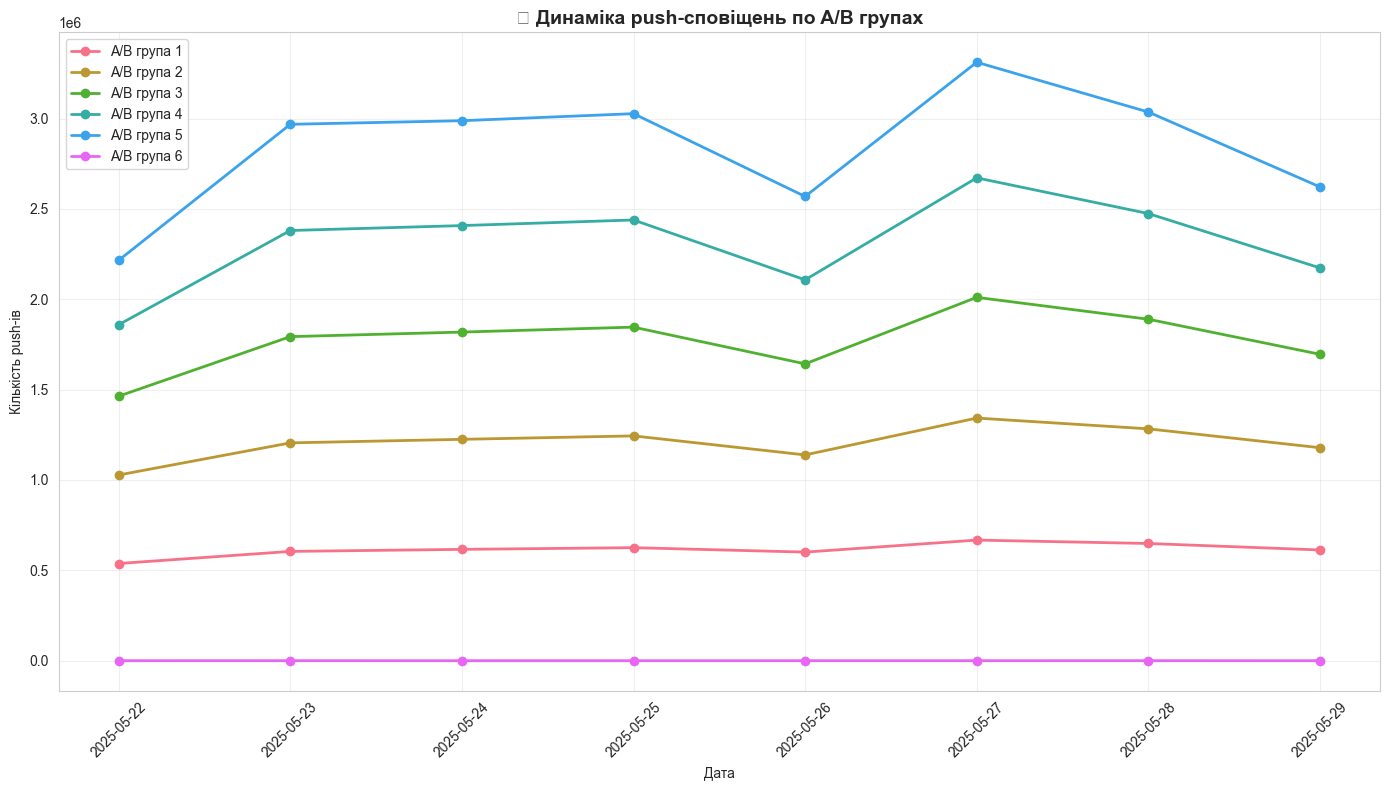


✅ Графік збережено: outputs/charts/ab_groups_temporal.png


In [9]:
# 2. Часова динаміка A/B груп
print("\n📅 Часова динаміка A/B груп:")
ab_temporal_query = f"""
SELECT 
    toDate(e.created_at) as date,
    d.tag as ab_group,
    COUNT(*) as total_pushes,
    COUNT(DISTINCT d.gadid) as unique_users
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND d.tag IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY toDate(e.created_at), d.tag
ORDER BY date, ab_group
"""
ab_temporal = db_manager.query_to_df(stat_client, ab_temporal_query)
ab_temporal['date'] = pd.to_datetime(ab_temporal['date'])

# Pivot таблиця для візуалізації
ab_pivot = ab_temporal.pivot(index='date', columns='ab_group', values='total_pushes').fillna(0)

# Графік динаміки A/B груп
plt.figure(figsize=(14, 8))
for column in ab_pivot.columns:
    plt.plot(ab_pivot.index, ab_pivot[column], marker='o', label=f'A/B група {column}', linewidth=2)

plt.title('📈 Динаміка push-сповіщень по A/B групах', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Кількість push-ів')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../outputs/charts/ab_groups_temporal.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/ab_groups_temporal.png")

## 🌍 Географічний аналіз

🌍 ГЕОГРАФІЧНИЙ АНАЛІЗ

🏆 Топ-20 країн за кількістю користувачів:
                          country  unique_users  user_percentage  avg_pushes_per_user  avg_success_rate
                          Unknown       1769093            64.09            25.087690            0.1373
                        Argentina        471181            17.07            22.739200            0.2277
                            India        100773             3.65            22.122146            0.1992
                            Egypt         53209             1.93            22.184687            0.2509
                       Bangladesh         40984             1.48            21.438879            0.1805
                           France         36936             1.34            23.858377            0.3303
                            Italy         32415             1.17            25.138670            0.3289
                       Kazakhstan         27744             1.01            24.527249            0.2633

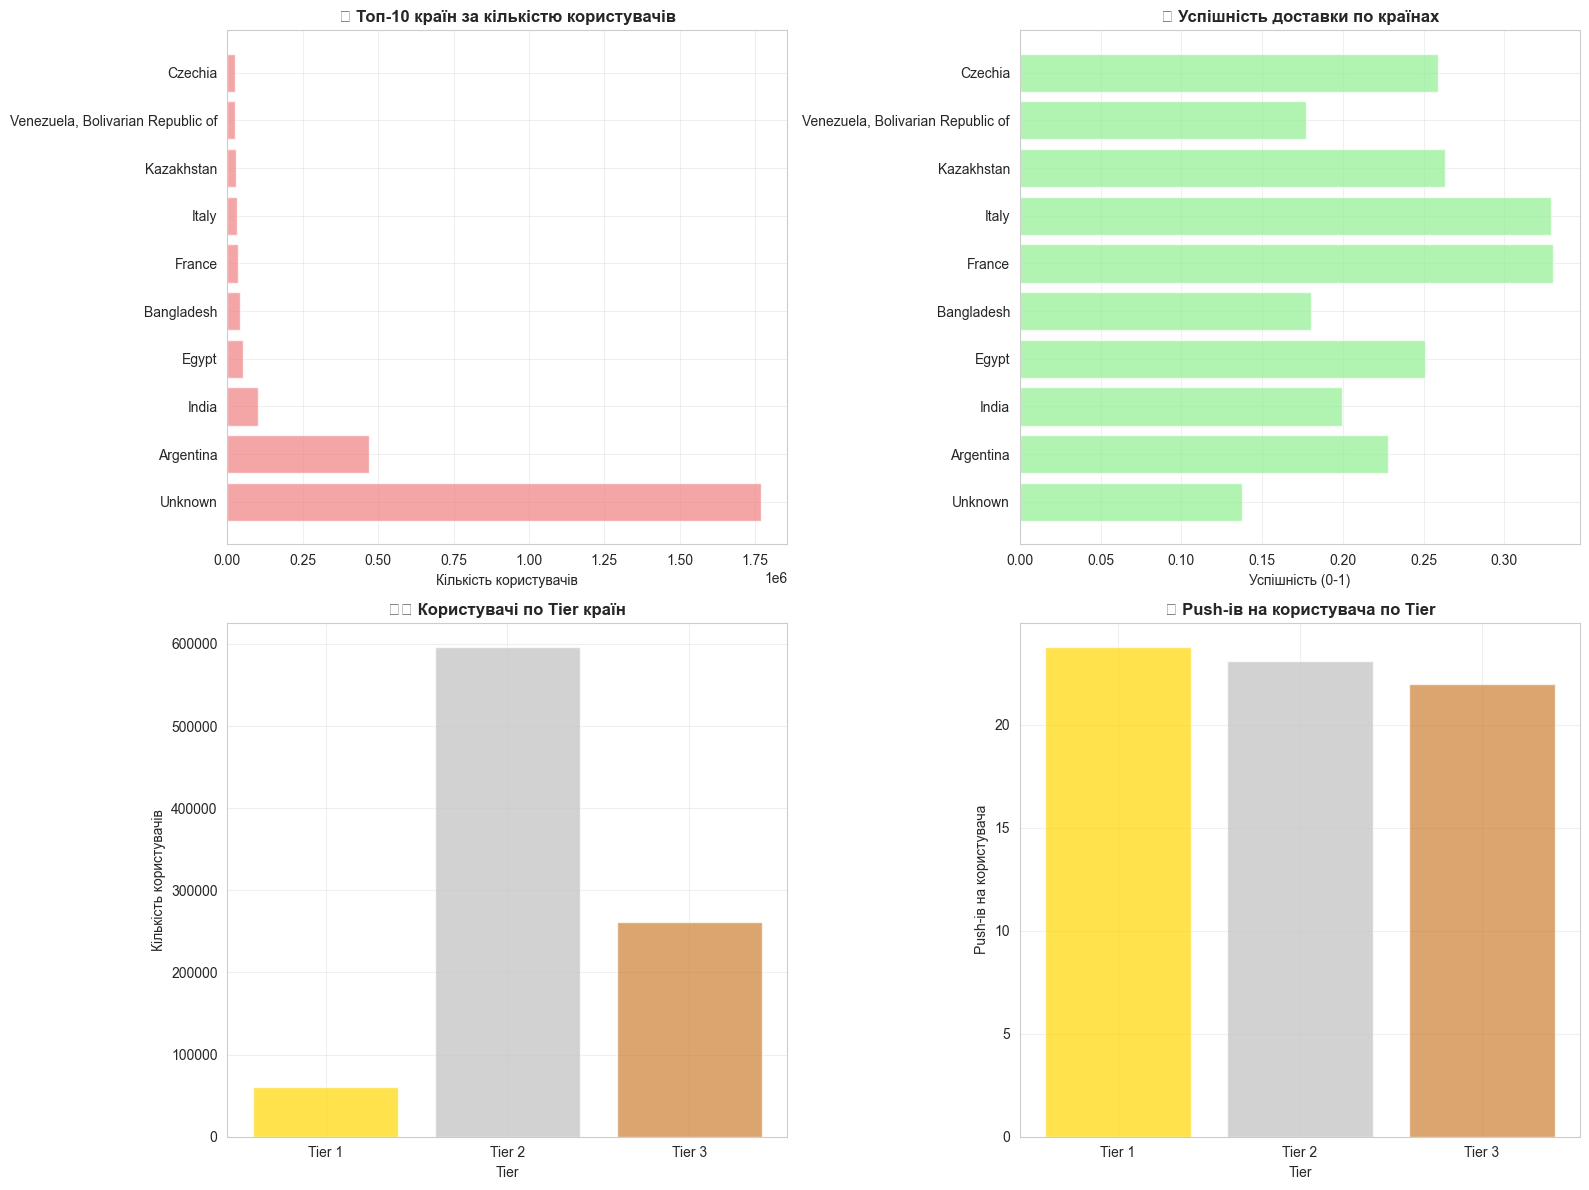


✅ Графік збережено: outputs/charts/geographic_analysis.png


In [10]:
print("🌍 ГЕОГРАФІЧНИЙ АНАЛІЗ")
print("=" * 30)

# 1. Топ країн за кількістю користувачів
countries_query = f"""
SELECT 
    COALESCE(d.country_name, 'Unknown') as country,
    COUNT(DISTINCT d.gadid) as unique_users,
    COUNT(*) as total_pushes,
    ROUND(AVG(e.sub_1), 4) as avg_success_rate,
    COUNT(*) / COUNT(DISTINCT d.gadid) as avg_pushes_per_user
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY d.country_name
ORDER BY unique_users DESC
LIMIT 20
"""
countries = db_manager.query_to_df(stat_client, countries_query)

print("\n🏆 Топ-20 країн за кількістю користувачів:")
countries['user_percentage'] = (countries['unique_users'] / countries['unique_users'].sum() * 100).round(2)
print(countries[['country', 'unique_users', 'user_percentage', 'avg_pushes_per_user', 'avg_success_rate']].to_string(index=False))

# Додавання Tier інформації
countries['tier'] = countries['country'].apply(get_country_tier)
countries_with_tier = countries[countries['country'] != 'Unknown']

print("\n🏷️ Розподіл країн по Tier:")
tier_summary = countries_with_tier.groupby('tier').agg({
    'unique_users': 'sum',
    'total_pushes': 'sum',
    'avg_success_rate': 'mean',
    'country': 'count'
}).round(4)
tier_summary.columns = ['unique_users', 'total_pushes', 'avg_success_rate', 'countries_count']
tier_summary['avg_pushes_per_user'] = (tier_summary['total_pushes'] / tier_summary['unique_users']).round(2)
print(tier_summary.to_string())

# Візуалізація географічного розподілу
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Топ-10 країн
top_countries = countries.head(10)
axes[0,0].barh(range(len(top_countries)), top_countries['unique_users'], alpha=0.7, color='lightcoral')
axes[0,0].set_yticks(range(len(top_countries)))
axes[0,0].set_yticklabels(top_countries['country'])
axes[0,0].set_title('🌍 Топ-10 країн за кількістю користувачів', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Кількість користувачів')
axes[0,0].grid(True, alpha=0.3)

# График 2: Успішність по країнах
axes[0,1].barh(range(len(top_countries)), top_countries['avg_success_rate'], alpha=0.7, color='lightgreen')
axes[0,1].set_yticks(range(len(top_countries)))
axes[0,1].set_yticklabels(top_countries['country'])
axes[0,1].set_title('📈 Успішність доставки по країнах', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Успішність (0-1)')
axes[0,1].grid(True, alpha=0.3)

# График 3: Розподіл по Tier
tier_data = tier_summary.reset_index()
tier_data = tier_data[tier_data['tier'] != 'Other']  # Виключаємо 'Other' для чистоти
axes[1,0].bar(tier_data['tier'], tier_data['unique_users'], alpha=0.7, color=['gold', 'silver', '#CD7F32'])
axes[1,0].set_title('🏷️ Користувачі по Tier країн', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Tier')
axes[1,0].set_ylabel('Кількість користувачів')
axes[1,0].grid(True, alpha=0.3)

# График 4: Push-и на користувача по Tier
axes[1,1].bar(tier_data['tier'], tier_data['avg_pushes_per_user'], alpha=0.7, color=['gold', 'silver', '#CD7F32'])
axes[1,1].set_title('📱 Push-ів на користувача по Tier', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Tier')
axes[1,1].set_ylabel('Push-ів на користувача')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/geographic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/geographic_analysis.png")

## 📊 Паттерни відправки push-сповіщень

📊 ПАТТЕРНИ ВІДПРАВКИ PUSH-СПОВІЩЕНЬ

📈 Розподіл кількості push-ів на користувача:
 push_count  users_count  percentage
          1        12127    0.390731
          2        18252    0.588078
          3        19434    0.626162
          4        23057    0.742894
          5        22600    0.728170
          6        39723    1.279871
          7       126953    4.090414
          8       375262   12.090908
          9        55406    1.785176
         10        19120    0.616045
         11        18180    0.585758
         12        19675    0.633927
         13        32909    1.060325
         14        89119    2.871406
         15       178711    5.758052

📊 Статистики розподілу push-ів:
 total_users  avg_pushes_per_user  median_pushes  min_pushes  max_pushes  q25_pushes  q75_pushes  q95_pushes
     2956767            24.811037           23.0           1     2068668        14.0        32.0        47.0


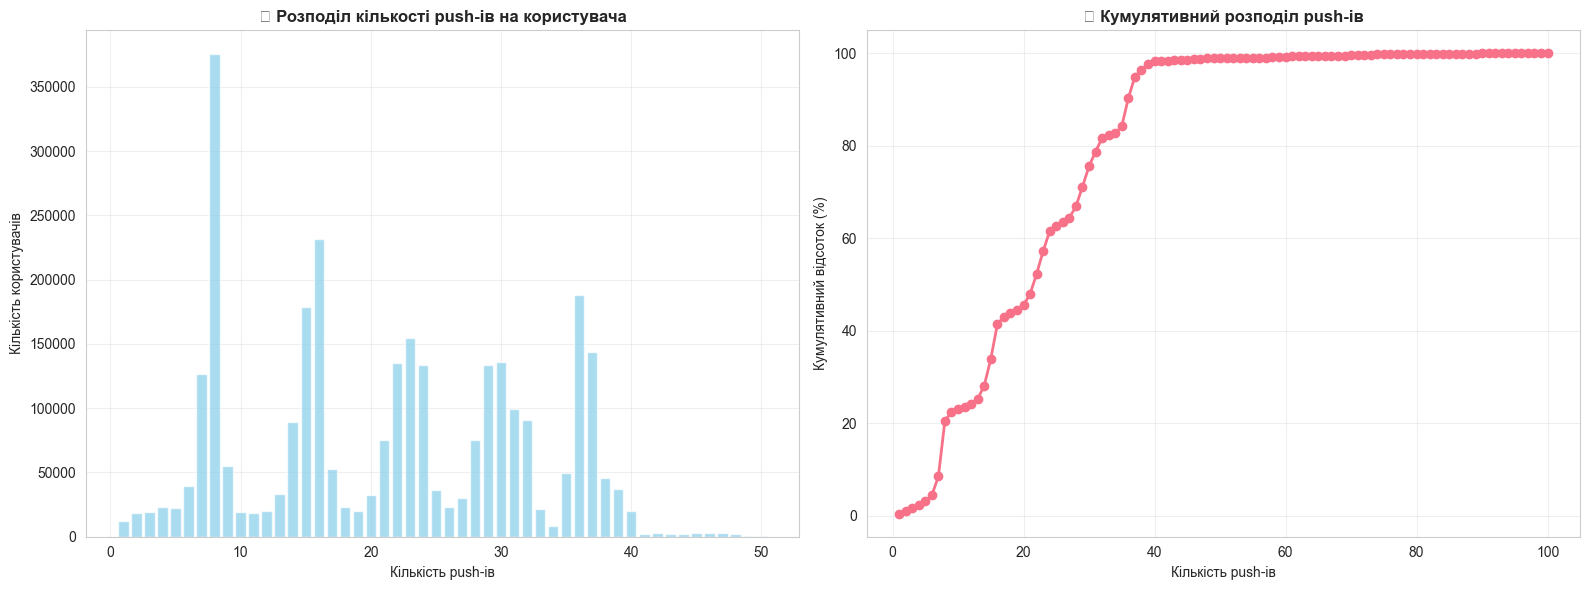


✅ Графік збережено: outputs/charts/push_distribution.png


In [11]:
print("📊 ПАТТЕРНИ ВІДПРАВКИ PUSH-СПОВІЩЕНЬ")
print("=" * 45)

# 1. Розподіл кількості push-ів на користувача
user_push_distribution_query = f"""
WITH user_pushes AS (
    SELECT 
        d.gadid,
        d.tag as ab_group,
        COUNT(*) as push_count,
        AVG(e.sub_1) as user_success_rate
    FROM event e
    JOIN device d ON e.device_id = d.id
    WHERE e.event_type = {PUSH_EVENT_TYPE}
        AND e.type = {ANDROID_TYPE}
        AND d.gadid IS NOT NULL
        AND d.tag IS NOT NULL
        AND toDate(e.created_at) >= '{PUSH_START_DATE}'
        AND toDate(e.created_at) <= '{PUSH_END_DATE}'
    GROUP BY d.gadid, d.tag
)
SELECT 
    push_count,
    COUNT(*) as users_count,
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() as percentage
FROM user_pushes
GROUP BY push_count
ORDER BY push_count
"""
push_distribution = db_manager.query_to_df(stat_client, user_push_distribution_query)

print("\n📈 Розподіл кількості push-ів на користувача:")
print(push_distribution.head(15).to_string(index=False))

# Статистики розподілу
push_stats_query = f"""
WITH user_pushes AS (
    SELECT 
        d.gadid,
        COUNT(*) as push_count
    FROM event e
    JOIN device d ON e.device_id = d.id
    WHERE e.event_type = {PUSH_EVENT_TYPE}
        AND e.type = {ANDROID_TYPE}
        AND d.gadid IS NOT NULL
        AND toDate(e.created_at) >= '{PUSH_START_DATE}'
        AND toDate(e.created_at) <= '{PUSH_END_DATE}'
    GROUP BY d.gadid
)
SELECT 
    COUNT(*) as total_users,
    AVG(push_count) as avg_pushes_per_user,
    quantile(0.5)(push_count) as median_pushes,
    MIN(push_count) as min_pushes,
    MAX(push_count) as max_pushes,
    quantile(0.25)(push_count) as q25_pushes,
    quantile(0.75)(push_count) as q75_pushes,
    quantile(0.95)(push_count) as q95_pushes
FROM user_pushes
"""
push_stats = db_manager.query_to_df(stat_client, push_stats_query)
print("\n📊 Статистики розподілу push-ів:")
print(push_stats.to_string(index=False))

# Візуалізація розподілу
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Розподіл кількості push-ів (до 50)
push_dist_filtered = push_distribution[push_distribution['push_count'] <= 50]
axes[0].bar(push_dist_filtered['push_count'], push_dist_filtered['users_count'], alpha=0.7, color='skyblue')
axes[0].set_title('📊 Розподіл кількості push-ів на користувача', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Кількість push-ів')
axes[0].set_ylabel('Кількість користувачів')
axes[0].grid(True, alpha=0.3)

# График 2: Кумулятивний розподіл
push_distribution['cumulative_percentage'] = push_distribution['percentage'].cumsum()
push_cum_filtered = push_distribution[push_distribution['push_count'] <= 100]
axes[1].plot(push_cum_filtered['push_count'], push_cum_filtered['cumulative_percentage'], marker='o', linewidth=2)
axes[1].set_title('📈 Кумулятивний розподіл push-ів', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Кількість push-ів')
axes[1].set_ylabel('Кумулятивний відсоток (%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/push_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/push_distribution.png")

## ✅ Аналіз успішності доставки

✅ АНАЛІЗ УСПІШНОСТІ ДОСТАВКИ


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



🧪 Успішність доставки по A/B групах:
ab_group  total_pushes  success_rate  unique_users
       1       4898325        0.1917        622669
       2       9629491        0.1902        625757
       3      14144512        0.1891        625118
       4      18498844        0.1890        625635
       5      22721515        0.1882        627793

🏷️ Успішність доставки по Tier:
   tier  total_pushes  successful_pushes  unique_users  success_rate
 Tier 1       2923722             942098        135612        0.3222
 Tier 2      14172325            3497668        679672        0.2468
 Tier 3       6277086            1400697        301221        0.2231
Unknown      40986014            5705052       1749410        0.1392


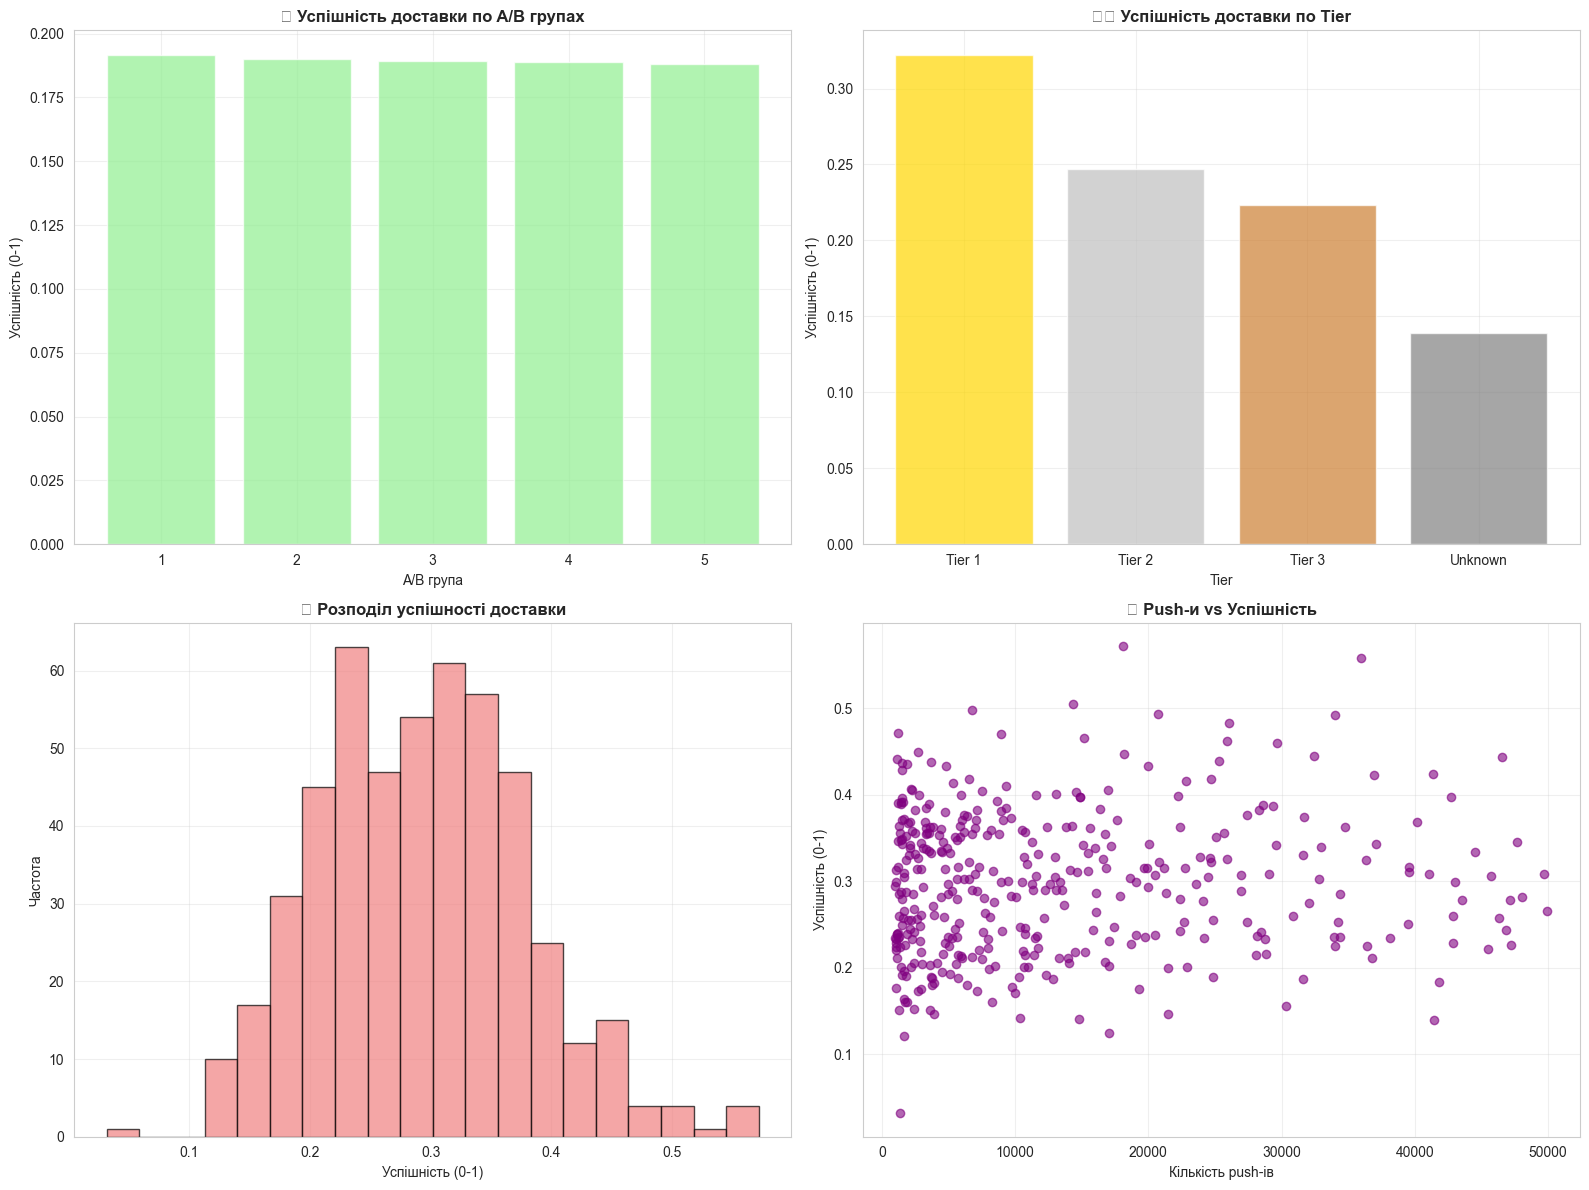


✅ Графік збережено: outputs/charts/success_analysis.png


In [12]:
print("✅ АНАЛІЗ УСПІШНОСТІ ДОСТАВКИ")
print("=" * 35)

# 1. Успішність по A/B групах та країнах
success_analysis_query = f"""
SELECT 
    d.tag as ab_group,
    COALESCE(d.country_name, 'Unknown') as country,
    COUNT(*) as total_pushes,
    SUM(e.sub_1) as successful_pushes,
    ROUND(AVG(e.sub_1), 4) as success_rate,
    COUNT(DISTINCT d.gadid) as unique_users
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND d.tag IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY d.tag, d.country_name
HAVING total_pushes >= 1000  -- Фільтруємо малі групи
ORDER BY ab_group, success_rate DESC
"""
success_analysis = db_manager.query_to_df(stat_client, success_analysis_query)

# Додавання Tier
success_analysis['tier'] = success_analysis['country'].apply(get_country_tier)

# Успішність по A/B групах
ab_success = success_analysis.groupby('ab_group').agg({
    'total_pushes': 'sum',
    'successful_pushes': 'sum',
    'unique_users': 'sum'
}).reset_index()
ab_success['success_rate'] = (ab_success['successful_pushes'] / ab_success['total_pushes']).round(4)

print("\n🧪 Успішність доставки по A/B групах:")
print(ab_success[['ab_group', 'total_pushes', 'success_rate', 'unique_users']].to_string(index=False))

# Успішність по Tier
tier_success = success_analysis[success_analysis['tier'] != 'Other'].groupby('tier').agg({
    'total_pushes': 'sum',
    'successful_pushes': 'sum',
    'unique_users': 'sum'
}).reset_index()
tier_success['success_rate'] = (tier_success['successful_pushes'] / tier_success['total_pushes']).round(4)

print("\n🏷️ Успішність доставки по Tier:")
print(tier_success.to_string(index=False))

# Візуалізація успішності
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Успішність по A/B групах
axes[0,0].bar(ab_success['ab_group'], ab_success['success_rate'], alpha=0.7, color='lightgreen')
axes[0,0].set_title('✅ Успішність доставки по A/B групах', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('A/B група')
axes[0,0].set_ylabel('Успішність (0-1)')
axes[0,0].grid(True, alpha=0.3)

# График 2: Успішність по Tier
color_map = {'Tier 1': 'gold', 'Tier 2': 'silver', 'Tier 3': '#CD7F32'}
colors = [color_map.get(tier, 'gray') for tier in tier_success['tier']]
axes[0,1].bar(tier_success['tier'], tier_success['success_rate'], alpha=0.7, color=colors)
axes[0,1].set_title('🏷️ Успішність доставки по Tier', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Tier')
axes[0,1].set_ylabel('Успішність (0-1)')
axes[0,1].grid(True, alpha=0.3)

# График 3: Розподіл успішності (гістограма)
success_rates = success_analysis['success_rate']
axes[1,0].hist(success_rates, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1,0].set_title('📊 Розподіл успішності доставки', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Успішність (0-1)')
axes[1,0].set_ylabel('Частота')
axes[1,0].grid(True, alpha=0.3)

# График 4: Кореляція між кількістю push-ів і успішністю
push_vs_success = success_analysis[success_analysis['total_pushes'] <= 50000]  # Фільтруємо викиди
axes[1,1].scatter(push_vs_success['total_pushes'], push_vs_success['success_rate'], alpha=0.6, color='purple')
axes[1,1].set_title('🔗 Push-и vs Успішність', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('Кількість push-ів')
axes[1,1].set_ylabel('Успішність (0-1)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/success_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Графік збережено: outputs/charts/success_analysis.png")

## 💾 Експорт даних для подальшого аналізу

In [17]:
print("💾 ЕКСПОРТ ДАНИХ ДЛЯ ПОДАЛЬШОГО АНАЛІЗУ")
print("=" * 45)

# Створюємо директорії для експорту
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../outputs/tables', exist_ok=True)

# 1. Експорт агрегованих даних по користувачах
print("\n📤 Експорт даних по користувачах...")
user_data_query = f"""
SELECT 
    toString(d.gadid) as gadid,
    d.tag as ab_group,
    COALESCE(d.country_name, 'Unknown') as country,
    COUNT(*) as total_pushes,
    SUM(e.sub_1) as successful_pushes,
    ROUND(AVG(e.sub_1), 4) as success_rate,
    MIN(e.created_at) as first_push,
    MAX(e.created_at) as last_push,
    COUNT(DISTINCT toDate(e.created_at)) as active_days
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND d.tag IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY d.gadid, d.tag, d.country_name
ORDER BY total_pushes DESC
"""

print("Завантаження даних по користувачах...")
user_data = db_manager.query_to_df(stat_client, user_data_query)

# Додаємо tier
user_data['tier'] = user_data['country'].apply(get_country_tier)

# Додаємо часові характеристики
user_data['first_push'] = pd.to_datetime(user_data['first_push'])
user_data['last_push'] = pd.to_datetime(user_data['last_push'])
user_data['campaign_duration_hours'] = (user_data['last_push'] - user_data['first_push']).dt.total_seconds() / 3600
user_data['pushes_per_day'] = (user_data['total_pushes'] / user_data['active_days']).round(2)

print(f"Завантажено {len(user_data):,} користувачів")

# Зберігаємо користувацькі дані
user_data.to_parquet('../data/processed/push_users_data.parquet')
user_data.to_csv('../outputs/tables/push_users_data.csv', index=False)
print("✅ Дані користувачів збережено в data/processed/push_users_data.parquet")

# 2. Експорт щоденної агрегації
print("\n📤 Експорт щоденної агрегації...")
daily_data_query = f"""
SELECT 
    toDate(e.created_at) as date,
    d.tag as ab_group,
    COALESCE(d.country_name, 'Unknown') as country,
    COUNT(*) as total_pushes,
    COUNT(DISTINCT d.gadid) as unique_users,
    SUM(e.sub_1) as successful_pushes,
    ROUND(AVG(e.sub_1), 4) as success_rate
FROM event e
JOIN device d ON e.device_id = d.id
WHERE e.event_type = {PUSH_EVENT_TYPE}
    AND e.type = {ANDROID_TYPE}
    AND d.gadid IS NOT NULL
    AND d.tag IS NOT NULL
    AND toDate(e.created_at) >= '{PUSH_START_DATE}'
    AND toDate(e.created_at) <= '{PUSH_END_DATE}'
GROUP BY toDate(e.created_at), d.tag, d.country_name
ORDER BY date, ab_group, country
"""

daily_data = db_manager.query_to_df(stat_client, daily_data_query)
daily_data['tier'] = daily_data['country'].apply(get_country_tier)
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Зберігаємо щоденні дані
daily_data.to_parquet('../data/processed/push_daily_data.parquet')
daily_data.to_csv('../outputs/tables/push_daily_data.csv', index=False)
print(f"✅ Щоденні дані збережено ({len(daily_data):,} записів)")

# 3. Створюємо summary статистики
print("\n📊 Створення summary статистик...")
summary_stats = {
    'period': f"{PUSH_START_DATE} - {PUSH_END_DATE}",
    'total_push_events': len(user_data) if 'total_pushes' in user_data.columns else 0,
    'unique_users': user_data['gadid'].nunique() if 'gadid' in user_data.columns else 0,
    'unique_ab_groups': user_data['ab_group'].nunique() if 'ab_group' in user_data.columns else 0,
    'unique_countries': user_data['country'].nunique() if 'country' in user_data.columns else 0,
    'avg_pushes_per_user': user_data['total_pushes'].mean() if 'total_pushes' in user_data.columns else 0,
    'median_pushes_per_user': user_data['total_pushes'].median() if 'total_pushes' in user_data.columns else 0,
    'overall_success_rate': user_data['success_rate'].mean() if 'success_rate' in user_data.columns else 0,
    'generated_at': datetime.now().isoformat()
}

# Зберігаємо summary
import json
with open('../outputs/tables/push_summary_stats.json', 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, ensure_ascii=False, indent=2)

print("✅ Summary статистики збережено")
print("\n📋 Підсумок експорту:")
print(f"- Користувацькі дані: {len(user_data):,} записів")
print(f"- Щоденні дані: {len(daily_data):,} записів")
print(f"- Унікальних користувачів: {summary_stats['unique_users']:,}")
print(f"- A/B груп: {summary_stats['unique_ab_groups']}")
print(f"- Країн: {summary_stats['unique_countries']}")

💾 ЕКСПОРТ ДАНИХ ДЛЯ ПОДАЛЬШОГО АНАЛІЗУ

📤 Експорт даних по користувачах...
Завантаження даних по користувачах...
Завантажено 3,132,011 користувачів
✅ Дані користувачів збережено в data/processed/push_users_data.parquet

📤 Експорт щоденної агрегації...
✅ Щоденні дані збережено (7,140 записів)

📊 Створення summary статистик...
✅ Summary статистики збережено

📋 Підсумок експорту:
- Користувацькі дані: 3,132,011 записів
- Щоденні дані: 7,140 записів
- Унікальних користувачів: 2,824,736
- A/B груп: 6
- Країн: 208


## 💡 Ключові інсайти та висновки

In [15]:
print("💡 КЛЮЧОВІ ІНСАЙТИ З EDA STATISTIC")
print("=" * 45)

# Аналізуємо основні паттерни на основі завантажених даних
if 'user_data' in locals() and not user_data.empty:
    print("\n🔍 ОСНОВНІ ВИСНОВКИ:")
    print("-" * 25)
    
    # 1. Загальна статистика
    total_users = len(user_data)
    total_pushes = user_data['total_pushes'].sum()
    avg_pushes = user_data['total_pushes'].mean()
    
    print(f"📊 МАСШТАБ ДАНИХ:")
    print(f"   • Унікальних користувачів: {total_users:,}")
    print(f"   • Загальна кількість push-ів: {total_pushes:,}")
    print(f"   • Середня кількість push-ів на користувача: {avg_pushes:.1f}")
    
    # 2. A/B групи
    ab_distribution = user_data['ab_group'].value_counts().sort_index()
    print(f"\n🧪 A/B ГРУПИ:")
    for ab_group, count in ab_distribution.items():
        percentage = count / total_users * 100
        avg_pushes_group = user_data[user_data['ab_group'] == ab_group]['total_pushes'].mean()
        print(f"   • Група {ab_group}: {count:,} користувачів ({percentage:.1f}%), ~{avg_pushes_group:.1f} push-ів")
    
    # 3. Географія
    tier_distribution = user_data['tier'].value_counts()
    print(f"\n🌍 ГЕОГРАФІЧНИЙ РОЗПОДІЛ:")
    for tier, count in tier_distribution.items():
        percentage = count / total_users * 100
        avg_success = user_data[user_data['tier'] == tier]['success_rate'].mean()
        print(f"   • {tier}: {count:,} користувачів ({percentage:.1f}%), успішність: {avg_success:.3f}")
    
    # 4. Успішність доставки
    overall_success = user_data['success_rate'].mean()
    success_std = user_data['success_rate'].std()
    print(f"\n✅ УСПІШНІСТЬ ДОСТАВКИ:")
    print(f"   • Загальна успішність: {overall_success:.3f} ± {success_std:.3f}")
    print(f"   • Мінімальна успішність: {user_data['success_rate'].min():.3f}")
    print(f"   • Максимальна успішність: {user_data['success_rate'].max():.3f}")
    
    # 5. Паттерни активності
    median_pushes = user_data['total_pushes'].median()
    q75_pushes = user_data['total_pushes'].quantile(0.75)
    q95_pushes = user_data['total_pushes'].quantile(0.95)
    
    print(f"\n📈 ПАТТЕРНИ АКТИВНОСТІ:")
    print(f"   • Медіана push-ів на користувача: {median_pushes:.0f}")
    print(f"   • 75% квантиль: {q75_pushes:.0f}")
    print(f"   • 95% квантиль: {q95_pushes:.0f}")
    
    heavy_users = len(user_data[user_data['total_pushes'] > q95_pushes])
    print(f"   • 'Важких' користувачів (>95% квантиль): {heavy_users:,} ({heavy_users/total_users*100:.1f}%)")

print("\n🎯 РЕКОМЕНДАЦІЇ ДЛЯ ПОДАЛЬШОГО АНАЛІЗУ:")
print("-" * 45)
print("1. 📊 Поглибити аналіз A/B груп та їх ефективності")
print("2. 🌍 Дослідити географічні відмінності в поведінці")
print("3. ⏰ Вивчити часові паттерни та оптимальний тайминг")
print("4. 🔗 Провести матчинг з конверсійними даними")
print("5. 📈 Розробити модель оптимальної кількості push-ів")

print("\n" + "=" * 60)
print("✅ EDA STATISTIC ЗАВЕРШЕНО!")
print("🚀 Готово до переходу на аналіз KEITARO")
print("=" * 60)

💡 КЛЮЧОВІ ІНСАЙТИ З EDA STATISTIC

🔍 ОСНОВНІ ВИСНОВКИ:
-------------------------
📊 МАСШТАБ ДАНИХ:
   • Унікальних користувачів: 3,132,011
   • Загальна кількість push-ів: 69,964,082
   • Середня кількість push-ів на користувача: 22.3

🧪 A/B ГРУПИ:
   • Група 1: 624,879 користувачів (20.0%), ~7.9 push-ів
   • Група 2: 626,824 користувачів (20.0%), ~15.4 push-ів
   • Група 3: 625,849 користувачів (20.0%), ~22.6 push-ів
   • Група 4: 626,170 користувачів (20.0%), ~29.6 push-ів
   • Група 5: 628,265 користувачів (20.1%), ~36.2 push-ів
   • Група 6: 24 користувачів (0.0%), ~22.8 push-ів

🌍 ГЕОГРАФІЧНИЙ РОЗПОДІЛ:
   • Unknown: 1,749,414 користувачів (55.9%), успішність: 0.141
   • Tier 2: 679,902 користувачів (21.7%), успішність: 0.270
   • Tier 3: 301,230 користувачів (9.6%), успішність: 0.248
   • Other: 265,848 користувачів (8.5%), успішність: 0.324
   • Tier 1: 135,617 користувачів (4.3%), успішність: 0.348

✅ УСПІШНІСТЬ ДОСТАВКИ:
   • Загальна успішність: 0.204 ± 0.392
   • Мінімальна у